In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite
/kaggle/input/spiral/Spiral.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
import scipy.cluster.hierarchy as shc
import seaborn as sns

In [3]:
# iris, spiral
DATASET = 'iris'

In [4]:
if(DATASET == 'iris'):
    X = pd.read_csv('../input/iris/Iris.csv')

    # Dropping the target column from the data
    Y = X[['Species']]
    X = X.drop('Species', axis = 1)
    
    # Scaling the data so that all the features become comparable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Normalizing the data so that the data approximately 
    # follows a Gaussian distribution
    X_normalized = normalize(X_scaled)

    # Converting the numpy array into a pandas DataFrame
    X_normalized = pd.DataFrame(X_normalized)
    
    pca = PCA(n_components = 2)
    X_principal = pca.fit_transform(X_normalized)
    X_principal = pd.DataFrame(X_principal)
    X_principal.columns = ['P1', 'P2']
    
elif(DATASET == 'spiral'):
    X = pd.read_csv('../input/spiral/Spiral.csv')

    # Dropping the target column from the data
    Y = X[['label']]
    Y = Y.rename(columns={'label': 'Species'})
    X = X.drop('label', axis = 1)
    
    X_principal = X

In [5]:
X_principal.head()

,P1,P2
0,1.096621,-0.221490
1,1.060033,0.182294
2,1.099548,0.065571
3,1.080044,0.155045
4,1.094720,-0.267872


In [6]:
Y.head()

,Species
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


In [7]:
Y['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [8]:
print(f'Number of Samples: {X_principal.shape[0]}')

Number of Samples: 150


In [9]:
if(DATASET == 'spiral'):
    fig = plt.figure(figsize =(6, 6))
    scatter = plt.scatter(X_principal.iloc[:, 0], X_principal.iloc[:, 1], c = Y['Species'], cmap ='rainbow')
    plt.legend(*scatter.legend_elements())
    plt.show()

    fig.savefig(f'{DATASET}_visualization.png', bbox_inches='tight')

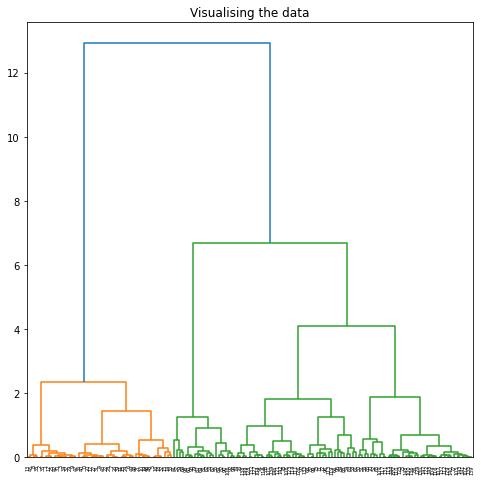

In [10]:
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

In [11]:
# Calculate Scores
def get_scores(X_principal, labels, num_cluster):
    ss = round(silhouette_score(X_principal, labels), 1)
    db = round(davies_bouldin_score(X_principal, labels), 1)
    ch = round(calinski_harabasz_score(X_principal, labels), 1)
    
    x_ = X_principal.copy()
    x_ = pd.DataFrame(x_)
    x_.loc[:,'Cluster'] = labels
    frames = [Y, x_['Cluster']]
    result = pd.concat(frames, axis = 1)
    result = get_labelled_clusters(num_cluster, result)
    
    hs = round(homogeneity_score(Y['Species'], result['TransLabel']), 1)
    cs = round(completeness_score(Y['Species'], result['TransLabel']), 1)
    vs = round(v_measure_score(Y['Species'], result['TransLabel']), 1)
    ar = round(adjusted_rand_score(Y['Species'], result['TransLabel']), 1)
    am = round(adjusted_mutual_info_score(Y['Species'], result['TransLabel']), 1)
    
    Correct = (Y['Species'] == result['TransLabel']).sum()
    acc = round(Correct/Y.shape[0], 1)
    
    return acc, ss, db, ch, hs, cs, vs, ar, am

def get_secondary_exp_result(X_principal, labels, num_clusters, type_exp, type_exp_val):
    acc, ss, db, ch, hs, cs, vs, ar, am = get_scores(X_principal,  labels, num_clusters)
    result = {'Num. Clusters': num_clusters,
              type_exp: type_exp_val,
              'Accuracy': acc,
              'Silhouette Score': ss,
              'Davies-Bouldin Score': db,
              'Calinski-Harabasz Score': ch,
              'Homogeneity Score': hs,
              'Completeness Score': cs,
              'V Measure Score': vs,
              'Adjusted Rand Score': ar,
              'Adjusted Mutual Info Score': am}
    return result

def get_labelled_clusters(num_clusters, result):
    for ClusterNum in range(num_clusters):
        OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('Species').size())
        OneCluster.columns=['Size']
        NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
        rowIndex = result.index[result['Cluster'] == ClusterNum]
        result.loc[rowIndex, 'TransLabel'] = NewDigit[0]
    return result

## Primary Experiment: Number of Clusters

In [12]:
MAX_CLUSTERS = X_principal.shape[0]
experiment_results = pd.DataFrame()

for num_cluster in range(2, MAX_CLUSTERS):
    ac = AgglomerativeClustering(n_clusters = num_cluster).fit(X_principal)
    acc, ss, db, ch, hs, cs, vs, ar, am = get_scores(X_principal,  ac.labels_, num_cluster)
    result = {'Num. Clusters': num_cluster,
              'Accuracy': acc,
              'Silhouette Score': ss,
              'Davies-Bouldin Score': db,
              'Calinski-Harabasz Score': ch,
              'Homogeneity Score': hs,
              'Completeness Score': cs,
              'V Measure Score': vs,
              'Adjusted Rand Score': ar,
              'Adjusted Mutual Info Score': am}
    experiment_results = experiment_results.append(result, ignore_index = True)

In [13]:
if(DATASET == 'iris'):
    x_axis = 5
elif(DATASET == 'spiral'):
    x_axis = 8

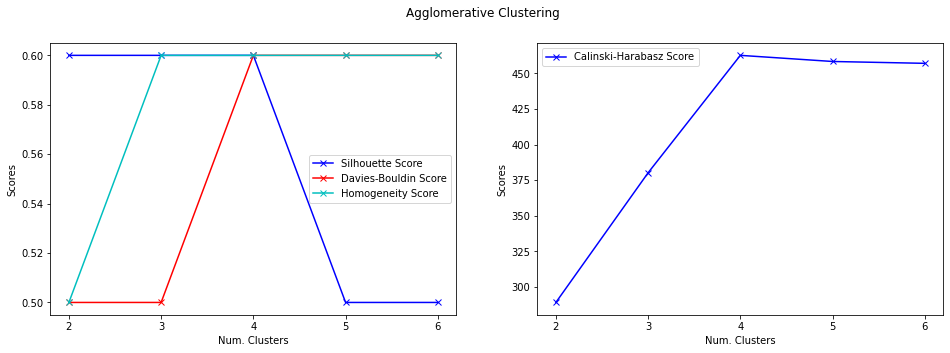

In [14]:
x = experiment_results['Num. Clusters'].iloc[0:x_axis]
accuracy = experiment_results['Accuracy'].iloc[0:x_axis]
ss = experiment_results['Silhouette Score'].iloc[0:x_axis]
bs = experiment_results['Davies-Bouldin Score'].iloc[0:x_axis]
hs = experiment_results['Homogeneity Score'].iloc[0:x_axis]
cs = experiment_results['Completeness Score'].iloc[0:x_axis]
vs = experiment_results['V Measure Score'].iloc[0:x_axis]
ar = experiment_results['Adjusted Rand Score'].iloc[0:x_axis]
am = experiment_results['Adjusted Mutual Info Score'].iloc[0:x_axis]
ch = experiment_results['Calinski-Harabasz Score'].iloc[0:x_axis]

# Plot Configuration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Agglomerative Clustering')

# ax1.plot(x, accuracy, 'gx-', label="Accuracy")
ax1.plot(x, ss, 'bx-', label="Silhouette Score")
ax1.plot(x, bs, 'rx-', label="Davies-Bouldin Score")
ax1.plot(x, hs, 'cx-', label="Homogeneity Score")
# ax1.plot(x, cs, 'mx-', label="Completeness Score")
# ax1.plot(x, vs, 'yx-', label="V Measure Score")
# ax1.plot(x, ar, 'kx-', label="Adjusted Rand Score")
# ax1.plot(x, am, 'gx-', label="Adjusted Mutual Info Score")
ax1.set_xlabel('Num. Clusters')
ax1.set_ylabel('Scores')
ax1.legend()
ax1.set_xticks(np.arange(min(x), max(x)+1, 1))

ax2.plot(x, ch, 'bx-', label = "Calinski-Harabasz Score")
ax2.set_xlabel('Num. Clusters')
ax2.set_ylabel('Scores')
ax2.legend()
ax2.set_xticks(np.arange(min(x), max(x)+1, 1))

plt.show()

fig.savefig(f'{DATASET}_clustering.png', bbox_inches='tight')

## Secondary Experiment: Linkage Styles

In [15]:
if(DATASET == 'iris'):
    NUM_CLUSTERS = 3
elif(DATASET == 'spiral'):
    NUM_CLUSTERS = 5

In [16]:
linkage_types = ['ward', 'complete', 'average', 'single']
results = pd.DataFrame()

for linkage_type in linkage_types:
    ac = AgglomerativeClustering(n_clusters = NUM_CLUSTERS, linkage = linkage_type).fit(X_principal)
    result = get_secondary_exp_result(X_principal, ac.labels_, NUM_CLUSTERS, 'Linkage Type', linkage_type)
    results = results.append(result, ignore_index = True)

results.T

,0,1,2,3
Num. Clusters,3.0,3.0,3.0,3.0
Linkage Type,ward,complete,average,single
Accuracy,0.8,0.8,0.8,0.7
Silhouette Score,0.6,0.6,0.6,0.5
Davies-Bouldin Score,0.5,0.5,0.5,0.5
Calinski-Harabasz Score,380.2,459.3,459.3,154.3
Homogeneity Score,0.6,0.7,0.7,0.6
Completeness Score,0.7,0.7,0.7,1.0
V Measure Score,0.7,0.7,0.7,0.7
Adjusted Rand Score,0.6,0.6,0.6,0.6


## Secondary Experiment: Affinity Styles

In [17]:
affinity_types = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
results = pd.DataFrame()

for affinity_type in affinity_types:
    ac = AgglomerativeClustering(n_clusters = NUM_CLUSTERS, linkage = 'complete', affinity = affinity_type).fit(X_principal)
    result = get_secondary_exp_result(X_principal, ac.labels_, NUM_CLUSTERS, 'Affinity Type', affinity_type)
    results = results.append(result, ignore_index = True)

results.T

,0,1,2,3,4
Num. Clusters,3.0,3.0,3.0,3.0,3.0
Affinity Type,euclidean,l1,l2,manhattan,cosine
Accuracy,0.8,0.8,0.8,0.8,0.8
Silhouette Score,0.6,0.6,0.6,0.6,0.6
Davies-Bouldin Score,0.5,0.5,0.5,0.5,0.6
Calinski-Harabasz Score,459.3,380.2,459.3,380.2,452.9
Homogeneity Score,0.7,0.6,0.7,0.6,0.7
Completeness Score,0.7,0.7,0.7,0.7,0.7
V Measure Score,0.7,0.7,0.7,0.7,0.7
Adjusted Rand Score,0.6,0.6,0.6,0.6,0.6


## Secondary Experiment: Full Tree Computation

In [18]:
compute_full_tree_types = ['auto', True, False]
results = pd.DataFrame()

for compute_full_tree_type in compute_full_tree_types:
    ac = AgglomerativeClustering(n_clusters = NUM_CLUSTERS, compute_full_tree = compute_full_tree_type).fit(X_principal)
    result = get_secondary_exp_result(X_principal, ac.labels_, NUM_CLUSTERS, 'Compute Full Tree', compute_full_tree_type)
    results = results.append(result, ignore_index = True)

results.T

,0,1,2
Num. Clusters,3.0,3.0,3.0
Compute Full Tree,auto,True,False
Accuracy,0.8,0.8,0.8
Silhouette Score,0.6,0.6,0.6
Davies-Bouldin Score,0.5,0.5,0.5
Calinski-Harabasz Score,380.2,380.2,380.2
Homogeneity Score,0.6,0.6,0.6
Completeness Score,0.7,0.7,0.7
V Measure Score,0.7,0.7,0.7
Adjusted Rand Score,0.6,0.6,0.6
